In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from pyswarms.discrete.binary import BinaryPSO
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
import tkinter as tk
from tkinter import messagebox

In [3]:
# Load the newly uploaded CSV file
#new_file_path = "merged_filtered.csv"
#df = pd.read_csv(new_file_path)
# ─── 1. DATA LOADING & PREPROCESSING ───
df = pd.read_csv('merged_filtered.csv')
# Extract 2% of the data
df = df.sample(frac=0.80, random_state=42)  # random_state for reproducibility

In [4]:
df = df.drop_duplicates().dropna()
df.head()

,flow_duration,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,...,Std,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight,label
903878,0.405401,1371932.7,6.0,92.6,3454.200896,3454.200896,0,0,0,0,...,1961.632223,2020.4,6.039143e-05,5.5,66.519348,2774.166894,4.376121e+06,0.9,38.50,DNS_Spoofing
772173,2.110055,224.3,12.5,70.4,122.878986,122.878986,0,0,0,0,...,85.031404,129.7,1.145501e-02,5.5,15.377376,120.252565,9.858199e+03,0.9,38.50,BenignTraffic
785228,570.245991,18808.4,11.4,87.4,0.095301,0.095301,0,0,0,0,...,104.537798,117.0,1.668626e+08,13.5,18.965192,147.815000,1.093296e+04,1.0,244.60,DNS_Spoofing
722738,3.698082,2598537.0,17.0,64.0,1268.353898,1268.353898,0,0,0,0,...,0.000000,554.0,8.371143e+07,9.5,33.286634,0.000000,0.000000e+00,0.0,141.55,Mirai-udpplain
91375,0.361943,542196.4,6.0,81.7,1012.128711,1012.128711,0,0,0,0,...,1200.847838,2299.6,1.665202e+08,13.5,38.321953,1655.961143,1.389883e+06,1.0,244.60,BenignTraffic


In [5]:
df.columns
print(df.nunique())

flow_duration      104117
Header_Length       97806
Protocol Type         975
Duration             4165
Rate               104742
Srate              104742
Drate                   1
fin_flag_number         2
syn_flag_number         2
rst_flag_number         2
psh_flag_number         2
ack_flag_number         2
ece_flag_number         2
cwr_flag_number         2
ack_count              88
syn_count             272
fin_count             102
urg_count            8887
rst_count           24277
HTTP                    2
HTTPS                   2
DNS                     2
Telnet                  1
SMTP                    1
SSH                     2
IRC                     1
TCP                     2
UDP                     2
DHCP                    1
ARP                     2
ICMP                    2
IPv                     2
LLC                     2
Tot sum             49554
Min                 10852
Max                 14826
AVG                 74985
Std                 74191
Tot size    

In [6]:
# Separate features & target
TARGET = 'label'
X = df.drop(TARGET, axis=1)
y = df[TARGET]
#if y.dtype == 'object':
 #   y = LabelEncoder().fit_transform(y)
# Encode target labels
if y.dtype == 'object':
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)
else:
    label_encoder = None




In [7]:
     
# Scale features
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)



In [8]:
# Balance classes

smote = SMOTE(random_state=42, k_neighbors=1)
X_res, y_res = smote.fit_resample(X, y)
#X_res, y_res = SMOTE(random_state=42).fit_resample(X, y)



In [9]:
# ─── 2. HYBRID BINARY GWO-PSO FEATURE SELECTOR ───
class HybridGWO_PSO:
    def __init__(self, n_particles, n_dims, iters,
                 w=0.8, c1=0.5, c2=0.3, alpha_blend=0.7):
        self.P = n_particles
        self.D = n_dims
        self.T = iters
        self.w, self.c1, self.c2 = w, c1, c2
        self.alpha = alpha_blend
        # Initialize binary positions & velocities
        self.X = np.random.randint(0, 2, size=(self.P, self.D))
        self.V = np.zeros((self.P, self.D))
        self.fitness = np.full(self.P, np.inf)

    def _sigmoid(self, v):
        return 1 / (1 + np.exp(-v))

    def _evaluate(self, X_mask):
        # Evaluate RF accuracy under mask
        idx = np.where(X_mask == 1)[0]
        if len(idx)==0: return 1.0
        X_sub = X_res.iloc[:, idx]
        clf = RandomForestClassifier(n_estimators=20, random_state=0)
        return 1 - cross_val_score(clf, X_sub, y_res, cv=3, scoring='accuracy').mean()

    def optimize(self):
        # Initial fitness
        for i in range(self.P):
            self.fitness[i] = self._evaluate(self.X[i])
        # Identify alpha, beta, delta
        order = np.argsort(self.fitness)
        alpha, beta, delta = order[:3]
        X_best = self.X[alpha].copy()

        for t in range(self.T):
            a = 2 * (1 - t/self.T)  # GWO linearly decreasing
            for i in range(self.P):
                # GWO position X_gwo
                X_gwo = np.zeros(self.D)
                for wolf in [alpha, beta, delta]:
                    r1, r2 = np.random.rand(self.D), np.random.rand(self.D)
                    A = 2*a*r1 - a
                    C = 2*r2
                    D = np.abs(C* self.X[wolf] - self.X[i])
                    X_gwo += self.X[wolf] - A*D
                X_gwo = X_gwo / 3
                # PSO velocity & position
                self.V[i] = (self.w*self.V[i]
                             + self.c1*np.random.rand(self.D)*(X_gwo - self.X[i])
                             + self.c2*np.random.rand(self.D)*(X_best - self.X[i]))
                S = self._sigmoid(self.V[i])
                X_pso = (np.random.rand(self.D) < S).astype(int)
                # Hybrid merge
                X_hybrid = ((self.alpha*X_gwo + (1-self.alpha)*X_pso) > 0.5).astype(int)
                self.X[i] = X_hybrid

 # Re-evaluate
                self.fitness[i] = self._evaluate(self.X[i])
                # Update α, β, δ, global best
            order = np.argsort(self.fitness)
            alpha, beta, delta = order[:3]
            if self.fitness[alpha] < self._evaluate(X_best):
                X_best = self.X[alpha].copy()

            print(f"Iter {t+1}/{self.T}, Best fitness: {self.fitness[alpha]:.4f}")

        return X_best




In [10]:

# Run feature selection
selector = HybridGWO_PSO(
    n_particles=20,
    n_dims=X_res.shape[1],
    iters=10,
    w=0.8, c1=0.5, c2=0.3, alpha_blend=0.7
)
best_mask = selector.optimize()
selected_idx = np.where(best_mask==1)[0]
selected_features = X.columns[selected_idx]
print("Selected features:", selected_features )

Iter 1/10, Best fitness: 0.0124
Iter 2/10, Best fitness: 0.0123
Iter 3/10, Best fitness: 0.0124
Iter 4/10, Best fitness: 0.0125
Iter 5/10, Best fitness: 0.0125
Iter 6/10, Best fitness: 0.0128
Iter 7/10, Best fitness: 0.0123
Iter 8/10, Best fitness: 0.0123
Iter 9/10, Best fitness: 0.0125
Iter 10/10, Best fitness: 0.0125
Selected features: Index(['flow_duration', 'Header_Length', 'Protocol Type', 'Duration', 'Rate',
       'Drate', 'fin_flag_number', 'syn_flag_number', 'psh_flag_number',
       'ece_flag_number', 'cwr_flag_number', 'ack_count', 'syn_count',
       'rst_count', 'HTTPS', 'DNS', 'IRC', 'TCP', 'UDP', 'Tot sum', 'Min',
       'AVG', 'IAT', 'Variance', 'Weight'],
      dtype='object')


In [11]:
# ─── 3. RANDOM FOREST TRAIN & EVAL ───
X_sel = X_res.iloc[:, selected_idx]
X_tr, X_te, y_tr, y_te = train_test_split(
    X_sel, y_res, test_size=0.3, random_state=42
)

rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_tr, y_tr)
y_pred = rf.predict(X_te)

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_te, y_pred))
print(confusion_matrix(y_te, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12083
           1       0.95      0.94      0.95     12208
           2       1.00      1.00      1.00     12142
           3       1.00      1.00      1.00     12270
           4       0.97      0.98      0.97     12151
           5       1.00      1.00      1.00     12129
           6       0.98      0.96      0.97     12122
           7       1.00      1.00      1.00     12156
           8       0.98      0.99      0.99     12153
           9       0.97      0.98      0.98     12215
          10       1.00      1.00      1.00     12256
          11       0.98      0.99      0.98     12086
          12       1.00      1.00      1.00     12090
          13       1.00      1.00      1.00     12265
          14       1.00      1.00      1.00     12081
          15       1.00      1.00      1.00     12315

    accuracy                           0.99    194722
   macro avg       0.99   

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_curve, auc,
    precision_recall_curve, average_precision_score
)
from sklearn.preprocessing import label_binarize
import numpy as np


In [13]:
y_proba = rf.predict_proba(X_te)  # shape: (n_samples, n_classes)

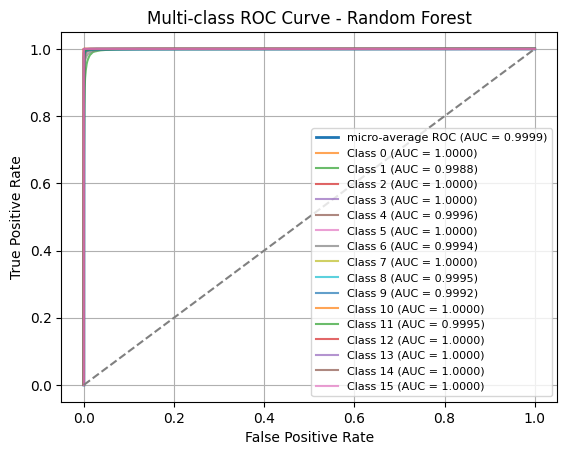

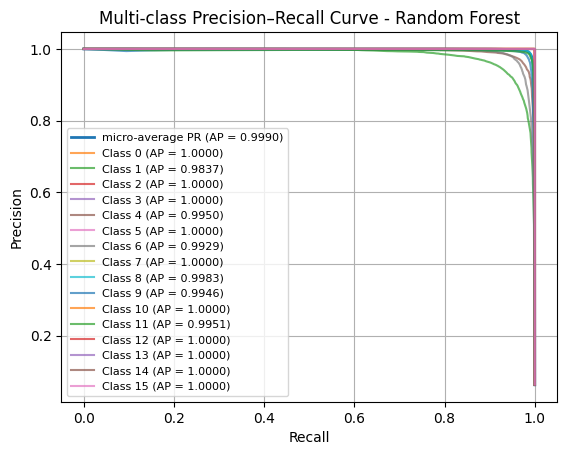

In [14]:
classes = np.unique(y_te)
n_classes = len(classes)

if n_classes > 2:
    # --- Binarize labels for one-vs-rest ---
    y_test_bin = label_binarize(y_te, classes=classes)  # shape: (n_samples, n_classes)

    # --- ROC & ROC-AUC per class ---
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Micro-average ROC
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_proba.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # ---- Plot ROC (micro + per class) ----
    plt.figure()
    plt.plot(
        fpr["micro"], tpr["micro"],
        label=f"micro-average ROC (AUC = {roc_auc['micro']:.4f})",
        linewidth=2
    )

    for i, cls in enumerate(classes):
        plt.plot(
            fpr[i], tpr[i],
            label=f"Class {cls} (AUC = {roc_auc[i]:.4f})",
            alpha=0.7
        )

    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Multi-class ROC Curve - Random Forest")
    plt.legend(loc="lower right", fontsize=8)
    plt.grid(True)
    plt.show()

    # --- Precision–Recall & AP per class ---
    precision = dict()
    recall = dict()
    average_precision = dict()

    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_proba[:, i])
        average_precision[i] = average_precision_score(y_test_bin[:, i], y_proba[:, i])

    # Micro-average PR
    precision["micro"], recall["micro"], _ = precision_recall_curve(
        y_test_bin.ravel(), y_proba.ravel()
    )
    average_precision["micro"] = average_precision_score(
        y_test_bin, y_proba, average="micro"
    )

    # ---- Plot PR (micro + per class) ----
    plt.figure()
    plt.plot(
        recall["micro"], precision["micro"],
        label=f"micro-average PR (AP = {average_precision['micro']:.4f})",
        linewidth=2
    )

    for i, cls in enumerate(classes):
        plt.plot(
            recall[i], precision[i],
            label=f"Class {cls} (AP = {average_precision[i]:.4f})",
            alpha=0.7
        )

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Multi-class Precision–Recall Curve - Random Forest")
    plt.legend(loc="lower left", fontsize=8)
    plt.grid(True)
    plt.show()

In [15]:
# ─── DETECTION LATENCY WITHOUT TIMESTAMP ───

df_stream = df.reset_index(drop=True)  # keep arrival order
X_stream = df_stream.drop(columns=[TARGET])
y_true_raw = df_stream[TARGET]

# Encode using same encoder as training
if label_encoder:
    y_true = label_encoder.transform(y_true_raw)
else:
    y_true = y_true_raw.values

# Scale & select features
X_stream_scaled = scaler.transform(X_stream)
X_stream_sel = X_stream_scaled[:, selected_idx]

# Predict using the IDS (RF)
y_pred = rf.predict(X_stream_sel)

# Identify attack label
attack_label = 1   # change if needed

def compute_flow_latency(y_true, y_pred, durations):
    latencies = []
    in_attack = False
    attack_start = None
    detected = False
    
    for i in range(len(y_true)):
        
        # Start of an attack episode
        if y_true[i] == attack_label and not in_attack:
            in_attack = True
            attack_start = i
            detected = False
        
        # First correct detection
        if in_attack and (y_pred[i] == attack_label) and not detected:
            latency_flows = i - attack_start
            latency_seconds = durations[attack_start:i+1].sum()
            latencies.append((latency_flows, latency_seconds))
            detected = True
        
        # Attack ends
        if y_true[i] != attack_label and in_attack:
            in_attack = False
    
    return latencies

durations = df_stream['flow_duration'].values
latencies = compute_flow_latency(y_true, y_pred, durations)

if len(latencies):
    flow_lat = [x[0] for x in latencies]
    time_lat = [x[1] for x in latencies]
    print("Average Detection Latency (flows):", np.mean(flow_lat))
    print("Average Detection Latency (seconds):", np.mean(time_lat))
    print("Number of attack episodes:", len(latencies))
else:
    print("No attack episodes detected.")

C:\Users\Darakhshan Syed\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Average Detection Latency (flows): 0.006965660515703288
Average Detection Latency (seconds): 39.50606383078573
Number of attack episodes: 24549


In [ ]:
# Prepare scaling parameters for selected features
means = scaler.mean_[selected_idx]
scales = scaler.scale_[selected_idx]

# ─── 4. GUI FOR PREDICTION ───
root = tk.Tk()
root.title("Hybrid IBGWO-PSO-RF Intrusion Detection System ")

def open_feature_window():
    win = tk.Toplevel(root)
    win.title("Enter Feature Values")
    entries = {}
    for i, feat in enumerate(selected_features):
        tk.Label(win, text=feat).grid(row=i, column=0, padx=5, pady=2, sticky='e')
        ent = tk.Entry(win)
        ent.grid(row=i, column=1, padx=5, pady=2)
        entries[feat] = ent

    def predict():
        try:
            raw_vals = np.array([float(entries[f].get()) for f in selected_features])
        except ValueError:
            messagebox.showerror("Invalid input", "Please enter numeric values for all features.")
            return
        # Scale raw inputs
        vals_scaled = (raw_vals - means) / scales
        pred = rf.predict(vals_scaled.reshape(1, -1))[0]
        if label_encoder:
            pred_label = label_encoder.inverse_transform([pred])[0]
        else:
            pred_label = str(pred)
        messagebox.showinfo("Prediction", f"Predicted attack type: {pred_label}")

    tk.Button(win, text="Predict", command=predict).grid(
        row=len(selected_features), column=0, columnspan=2, pady=10
    )

# Main window controls
tk.Label(root, text="Select Algorithm:").pack(pady=10)
algo_var = tk.StringVar(value="Hybrid IBGWO-PSO")
tk.OptionMenu(root, algo_var, "Hybrid IBGWO-PSO").pack()
tk.Button(root, text="Use Algorithm", command=open_feature_window).pack(pady=20)

root.mainloop()